### Data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data = data.drop(columns=["index"])

In [2]:
def pad(array, target_length):
    """
    Pads 1D array to target length using -1 constant as padding.
    e.g. pad([1,2,3], 5) -> [1,2,3,-1,-1]
    """

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [3]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row i in x is all of the timestamps for CX-i
# Each row i in y is all of the corresponding efficiency values for CX-i
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
# The rows are all padded to the length of the longest CX component.
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
# e.g., the padded array [1,2,3,-1,-1] has a mask [True, True, True, False, False]
# which tells the model to only model the first three values in the array.
mask = x_padded != -1

In [4]:
# Generate M1 to M5 arrays. Each M value is the same for all measurements within a CX component
M_df = data.drop_duplicates(subset=["ID"])

# M[0] is all M1 values, M[1] is all M2 values etc.
# M is of shape (5, 75), one M1-M5 value for each CX-i.
M = np.array([M_df["M1"], M_df["M2"], M_df["M3"], M_df["M4"], M_df["M5"]])

### Enhanced Model

Model the efficiency $y_i$ as a noisy exponential decay function $f_i$, with parameters $u_i$, $v_i$ and $w_i$:

$$y_i(t) = f_i(t) + \epsilon$$

$$f_i(t) = u_i \cdot \exp \left \{-\left (v_i + \sum \limits _{j=1} ^5 w_j m_{ji}\right ) t \right \}$$

We omit the 10,000 divisor since we already divided the timestamp earlier.

In [5]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, m, mask):
    # Define noise value to model epsilon
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX-i
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10)) # shape (75,)
        v = npr.sample("v", dist.Normal(3, 1))   # shape (75,)

    # Generate a w_j for each M_j
    with npr.plate("m", m.shape[0]):
        w = npr.sample("w", dist.Normal(0, 1)) # shape (5,)

    # Make predictions of f_i(t) then sample from normal dist with variance sigma to account for noise
    with npr.plate("observations", t.shape[1]):
        with npr.handlers.mask(mask=mask):
            # The sum in the equation is a matrix multiplication between w (5,) and m (5, 75)
            m_sum = -(v + jnp.matmul(w, m))
            # Same as in baseline model
            f = u[:, jnp.newaxis] * jnp.exp(m_sum[:, jnp.newaxis] * t)
            npr.sample("obs", dist.Normal(f, sigma), y)

In [6]:
from jax import random
from numpyro.infer import MCMC, NUTS

seed = 1
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
mcmc.print_summary()

C:\Users\david\AppData\Local\Temp\ipykernel_20672\1996289873.py:8: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
sample: 100%|██████████| 4000/4000 [00:11<00:00, 343.57it/s, 63 steps of size 7.19e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.07      0.13      5.07      4.85      5.28   2678.87      1.00
      u[0]     92.20      2.46     92.15     88.39     96.27   2677.85      1.00
      u[1]     91.79      2.49     91.80     87.49     95.77   2954.32      1.00
      u[2]     92.96      2.71     92.98     88.05     96.89   3384.83      1.00
      u[3]     91.75      4.22     91.75     85.21     99.08   2524.84      1.00
      u[4]     89.98      4.20     90.03     82.94     96.29   2047.43      1.00
      u[5]     94.58      6.12     94.36     83.94    104.36   1756.91      1.00
      u[6]     91.37      4.81     91.29     83.67     99.40   3374.35      1.00
      u[7]     90.83      4.72     90.76     83.07     98.54   3098.67      1.00
      u[8]    103.14      4.09    103.26     96.32    109.74   3386.91      1.00
      u[9]     89.02      4.51     88.88     81.32     95.68   3563.64      1.00
     u[10]     99.83      3

In [7]:
samples = mcmc.get_samples()

# v mean here should be lower than baseline, as suggested by the spec
jnp.abs(samples["v"]).mean()

Array(2.8273082, dtype=float32)

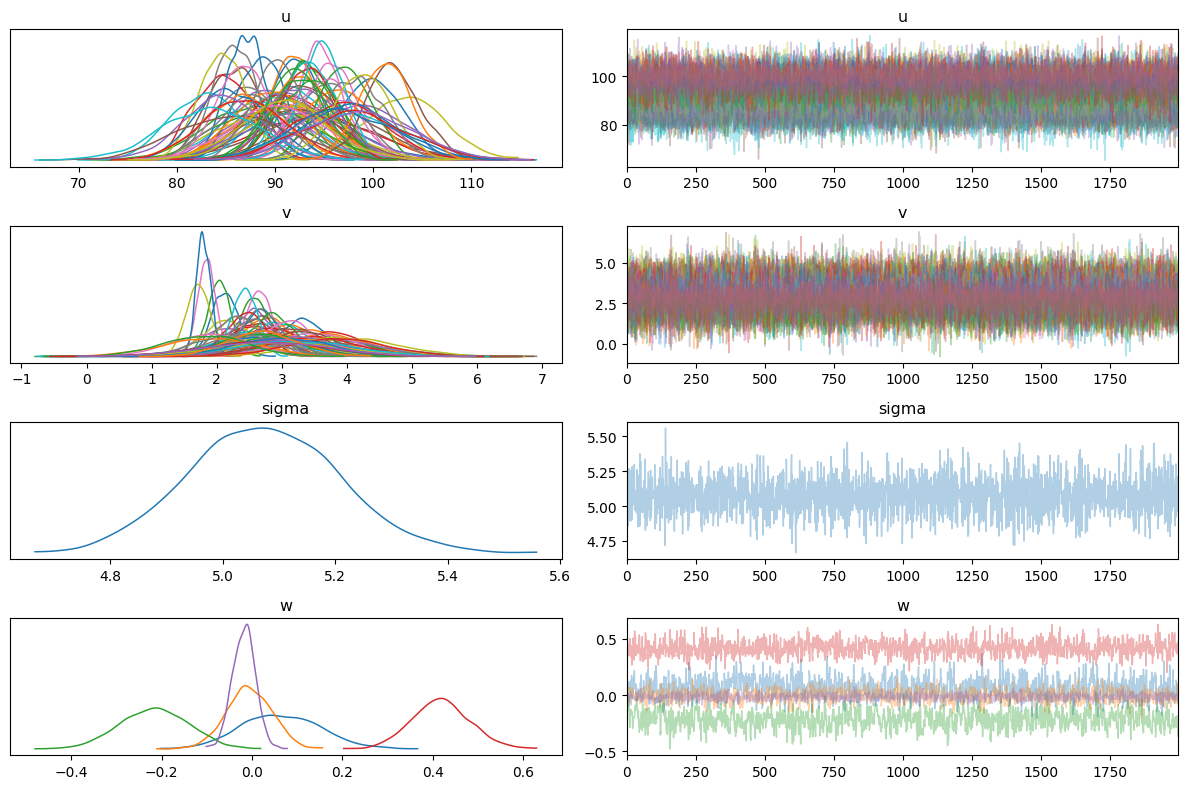

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

idata_enhanced = az.from_numpyro(mcmc)

az.plot_trace(
    idata_enhanced,
    var_names=["u", "v", "sigma", "w"], 
    compact=True,
)
plt.tight_layout()
plt.savefig("figure_B1_enhanced_trace_w.png", dpi=300, bbox_inches="tight")

### Save samples to file for deployable model

In [ ]:
import pickle

# Dump all the samples and the M values into a file for inference in deployable model
with open("deployable_model.pkl", "wb") as f:
    pickle.dump({"samples": samples, "m": M}, f)

### Visualisation

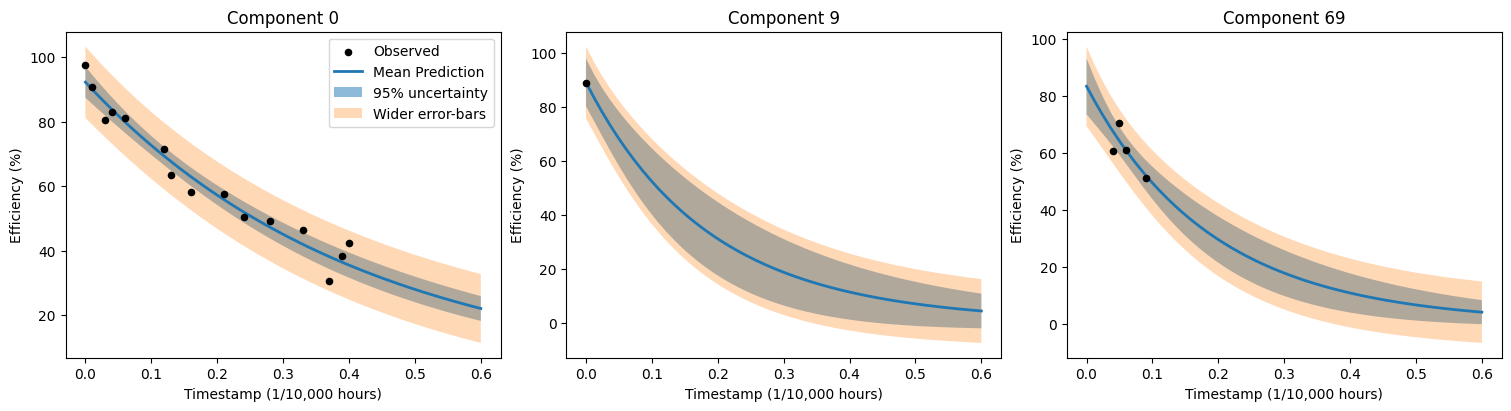

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(samples, t, y, M, plot_indices):
    plot_indices = np.array(plot_indices)

    u = samples['u']
    v = samples['v']
    w = samples['w']

    n = len(plot_indices)
    cols = 3
    rows = max(1, (n + cols - 1) // cols)

    _, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    axes = np.atleast_1d(axes).flatten()

    m_sum = -(v + jnp.dot(w, M))

    for i, ax in zip(plot_indices, axes):
        t_i = t[i]
        y_i = y[i]
    
        t_linspace = jnp.linspace(0, 0.6)

        u_i = u[:, i]
        m_i = m_sum[:, i]
        preds = u_i[:, None] * jnp.exp(m_i[:, None] * t_linspace)

        mean_pred = preds.mean(axis=0)

        std = jnp.std(preds, axis=0)
        low_95 = mean_pred - std * 1.96
        high_95 = mean_pred + std * 1.96

        avg_sigma = samples["sigma"].mean()

        noise_std = jnp.sqrt(std ** 2 + avg_sigma ** 2)

        low_wider = mean_pred - noise_std * 1.96
        high_wider = mean_pred + noise_std * 1.96

        ax.scatter(t_i, y_i, color="black", s=20, zorder=3, label="Observed")
        ax.plot(t_linspace, mean_pred, lw=2, label="Mean Prediction")
        ax.fill_between(t_linspace, low_95, high_95, alpha=0.5, label="95% uncertainty")
        ax.fill_between(t_linspace, low_wider, high_wider, alpha=0.3, label="Wider error-bars")

        ax.set_title(f"Component {i}")
        ax.set_xlabel("Timestamp (1/10,000 hours)")
        ax.set_ylabel("Efficiency (%)")

    axes[0].legend()

    for ax in axes[n:]:
        ax.axis("off")

    plt.show()

# Notice how much better the predicition is for component 9 in the enhanced model vs the baseline model
plot_component_fits(samples, x, y, M=M, plot_indices=[0, 9, 69])

### Blind Predictions

Predict probability over all $n$ samples and average.



In [ ]:
import jax.scipy.stats as stats

def predict_probability_below(samples, component: int, m: np.array, t: float = 40.0, y: float = 35.0):
    """
    Returns predicted probability of a component being below
    efficiency `y` at time `t`.
    """
    # Normalise t how we did for the models
    t /= 10_000

    # Get the component's M1 to M5 values
    m_component = m[:, component]

    # Get the samples from the component we are predicting
    s = samples["sigma"]
    u = samples["u"][:, component]
    v = samples["v"][:, component]
    w = samples["w"]

    # Calculate the f values like we did in the model
    m_sum = -(v + jnp.matmul(w, m_component))
    f = u * jnp.exp(m_sum * t)

    # Use cumulative distribution function to get probability of predicted efficiency `f` being under `y`
    # This returns a (n_samples,) array (1 probability value for each sample from mcmc)
    probs = stats.norm.cdf(y, loc=f, scale=s)

    # Return mean of sampled probabilities to get final prediction
    return probs.mean()

### Predictions sanity check

In [ ]:
# Predictions are incredibly small for default values, t=40 and y=35
predict_probability_below(samples, component=0, m=M)

Array(7.100876e-24, dtype=float32)

In [ ]:
# But the prediction is very reasonable if we look at when component 0 reaches 35%
# Check graph 0: around t=0.4 (which is t=4000 before dividing by 10,000) the y value is around 35%
# so a 0.46 probability makes sense
predict_probability_below(samples, component=0, m=M, t=4000)

Array(0.46106625, dtype=float32)

### Create CSV file for blind predictions

In [ ]:
from typing import List

In [ ]:
def blind_predictions_to_csv(samples, components: List[int], m: np.array, t: float = 40.0, y: float = 35.0):
    # Generate list of string "CX-00xx" for all components in the components list
    cx_names = [f"CX-{str(c).zfill(4)}" for c in components]
    predictions = []

    # Make predictions for each component at the t and y values
    for component in components:
        prediction = predict_probability_below(samples, component, m, t, y)
        predictions.append(prediction)

    predictions_df = pd.DataFrame({"ID": cx_names, "index": components, "probability": predictions})

    predictions_df.to_csv("predictions.csv", index=False)

blind_predictions_to_csv(samples, range(50, 75), M)